# 21S 인공지능 기초 Term Proejct

## : Maze Learning


## 2021년 06월 06일 안상호

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random, collections, copy

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

from IPython import display
%matplotlib inline

plt.rcParams["figure.figsize"] = (11, 11)




# 1. 기능별 설명

> 가운데 2 by 2가 goal이라고 가정, 이를 제외하고 랜덤하게 구조가 변경되는 것으로 생각

- 객체
    - 미로 생성
        1. `Room`
        2. `Maze`
        
    - 미로 학습
        1. `Agent`
- 학습용 코드
    1. 데이터셋 생성 (최적경로 탐색)
    2. 모델 생성 및 학습
    3. 테스트 코드

- 평가용 코드
    1. 미로 읽기: `read_maze()`
    2. 미로 탐색: `explore_maze()`
        - 실시간으로 보여줄 수 있어야함
        - 도착점 한곳에만 닿아도 
    3. 평가: `evaluate_solving()`
        - 총 걸린 시간 (회전, 이동 시간 고려)
        - 출발과 도착, 2phase에서 min 값으로 

## 1.1. 미로 학습 과정

### 미로 랜덤 생성 - `Maze`


In [2]:
class Room:
    def __init__(self, r, c):
        self.r, self.c = r, c
        self.visit = 0
        self.prev = None
        self.drct = [(r + 1, c), (r, c + 1),
                     (r - 1, c), (r, c - 1)]
        random.shuffle(self.drct)


class Maze:
    def __init__(self, size:int=32):
        self.size = size
        self.setup()
        
    def setup(self):
        self._maze = [[Room(r, c) for c in range(self.size)] for r in range(self.size)]
        self._mazeMap = [["1" for c in range(self.size * 2 + 1)] for r in range(self.size * 2 + 1)]
        self.__make(None, self._maze[0][0], self._maze)
        

        start = self.size - 1 # ()
        end = self.size + 1 # ()
        for i in range(start, end+1):
            for j in range(start, end+1):
                self._mazeMap[i][j] = "0"
                
        self._mazeMap[start][start] = self._mazeMap[start][end] = self._mazeMap[end][start] = self._mazeMap[end][end] = "3"
        self._mazeMap[1][1] = "2"
        self.maze = self._maze
        self.mazeMap = self._mazeMap
    
    def __make(self, prev, room:Room, maze:list):
        room.prev = prev
        if room.prev is not None:
            r = prev.r - room.r
            c = prev.c - room.c
            self._mazeMap[(room.r + 1) * 2 - 1 + r][(room.c + 1) * 2 - 1 + c] = "0"
            
        
        room.visit = 1
        self._mazeMap[(room.r + 1) * 2 - 1][(room.c + 1) * 2 - 1] = "0"
        while True:
            if len(room.drct) == 0:
                break
            nr, nc = room.drct.pop()
            if nr >= 0 and nr < self.size and nc >= 0 and nc < self.size:
                if not maze[nr][nc].visit == 1:
                    self.__make(room, maze[nr][nc], maze)
                
    def save(self, filename:str='maze.txt'):
        with open(filename, 'w') as f:
            for r in self.mazeMap:
                for c in r:
                    f.write(c)
                f.write('\n')
        

### 미로 랜덤 생성 - `Agent`

In [7]:
# free cell: 0, 벽: 1, 플레이어: 2, 골인: 3
# 수정한 
import copy

plt.rcParams["figure.figsize"] = (11, 11)

visited_mark = 0.75  # Cells visited by the rat will be painted by gray 0.8
player_mark = 0.8      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# For Train
information_dict = {
    "wall": 0.3,
    "free": 0.5,
    "visited": 0.75,
    "player": 0.9,
    "goal": 1.0

}

# For Drawing
mark_dict = {
    "wall": 0.0,
    "free": 1.0,
    "player": 0.3,
    "visited": 0.6,
    "goal": 0.9
}


# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

class Agent:
    def __init__(self, maze, player="2", goal="3"):
        self._convert_dict = {
            "0": information_dict["free"], # 이동가능
            "1": information_dict["wall"], # 벽
            player: information_dict["free"], # 플레이어
            goal: information_dict["free"] # 골인지점
        }
        self.player, self.target = (), []
        self._maze = self.__convert_maze_format(maze, player, goal)
        self.nrows, self.ncols = self._maze.shape
        self.free_cells = [(r, c) for r in range(self.nrows) for c in range(self.ncols) if self._maze[r, c] == information_dict["free"]]
        for tgt in self.target:
            self.free_cells.remove(tgt)
            if self._maze[tgt] == information_dict["wall"]:
                raise Exception("Invalid maze: target cell cannot be blocked!")
        if not self.player in self.free_cells:
            raise Exception("Invalid Player Location: must sit on a free cell")
        self.reset(self.player)            

    def __convert_maze_format(self, mazeMap:list, player, goal):
        maze_copy = copy.deepcopy(mazeMap)

        for i, line in enumerate(mazeMap):
            for j, elem in enumerate(mazeMap):
                current_elem = mazeMap[i][j]
                if current_elem == player:
                    self.player = (i, j)
                elif current_elem == goal:
                    self.target.append((i, j))
                maze_copy[i][j] = self._convert_dict[current_elem]

        return np.array(maze_copy)

    def reset(self, player):
        self.player = player
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = player
        self.maze[row, col] = information_dict["player"]
        self.state = (row, col, 'start')
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = player_row, player_col, mode = self.state

        if self.maze[player_row, player_col] > information_dict["wall"]:
            self.visited.add((player_row, player_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 2
                self.visited.add((player_row, player_col-1))
            elif action == UP:
                nrow -= 2
                self.visited.add((player_row-1, player_col))
            if action == RIGHT:
                ncol += 2
                self.visited.add((player_row, player_col+1))
            elif action == DOWN:
                nrow += 2
                self.visited.add((player_row+1, player_col))
                
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        
    def act(self, action):
        self.update_state(action)
        envstate = self.observe()
        return envstate

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = information_dict["free"]
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = information_dict["player"]
        return canvas

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        ## 가장자리 제거
        if row == 1: # UP 제거
            actions.remove(1)
        elif row == nrows-2: # DOWN 제거
            actions.remove(3)

        if col == 1: # LEFT 제거 
            actions.remove(0)
        elif col == ncols-2: # RIGHT 제거
            actions.remove(2)

        if row > 1 and self.maze[row-1,col] == information_dict["wall"]:
            actions.remove(1)
        if row<nrows-2 and self.maze[row+1,col] == information_dict["wall"]:
            actions.remove(3)

        if col>1 and self.maze[row,col-1] == information_dict["wall"]:
            actions.remove(0)
        if col<ncols-2 and self.maze[row,col+1] == information_dict["wall"]:
            actions.remove(2)

        return actions

    def show(self, external_maze=None):
        plt.grid('on')
        ax = plt.gca()
        ax.set_xticks(np.arange(0.5, self.nrows, 1))
        ax.set_yticks(np.arange(0.5, self.ncols, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if external_maze is not None:
            canvas = np.copy(external_maze)
        else:
            canvas = np.copy(self.maze)
        nrows, ncols = canvas.shape

        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = mark_dict["free"]
                else:
                    canvas[r, c] = mark_dict["wall"]


        for row, col in self.visited:
            canvas[row,col] = mark_dict["visited"]

        player_row, player_col, _ = self.state
        canvas[player_row, player_col] = mark_dict["player"]
        ## Goal Cell
        for target_row, target_col in self.target:
            canvas[target_row, target_col] = mark_dict["goal"]
        img = plt.imshow(canvas, interpolation='none', cmap='gray')
        return img

    def export_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = information_dict["free"]
        # draw the rat
        for row, col in self.visited:
            canvas[row,col] = information_dict["visited"]

        player_row, player_col, _ = self.state
        canvas[player_row, player_col] = information_dict["player"]
        
        ## Goal Cell
        for target_row, target_col in self.target:
            canvas[target_row, target_col] = information_dict["goal"]

        return canvas.reshape((1, -1))

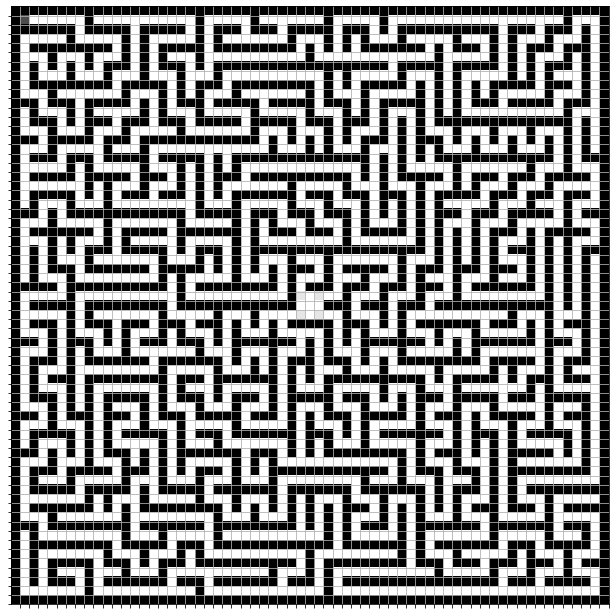

In [8]:
size = 32

maze = Maze(size)
# maze.save(f"maze_{size}_{size}.txt")

maze_agent = Agent(maze.mazeMap)
maze_agent.show()

### 최적 경로 탐색

In [27]:
def escRoot(pr, pc, prv, tree_map):
        for tmp in tree_map[pr][pc]:
            if (-1, -1) == tmp:
                sol.append((pr, pc))
                return 1
            
        for pos in tree_map[pr][pc]:
            if prv == pos:
                continue
            if escRoot(pos[0], pos[1], (pr, pc), tree_map) == 1:
                sol.append((pr, pc))
                return 1

# with open(map_path, 'r') as rf:
src = maze.mazeMap

        
mazeSize = int((len(src) - 1)/2)
tree_map, sol = [], []

## maze의 index 단위
for r in range(1, mazeSize + 1):
    tree_map.append([])
    for c in range(1, mazeSize + 1):
        tree_map[-1].append([])

## mazeMap의 index 단위
for  r in range(1, mazeSize*2, 2):
    for c in range(1, mazeSize*2, 2):
        rr, cc = int((r+1)/2)-1, int((c+1)/2)-1 # Room 좌표
        if src[r-1][c] == "0":
            tree_map[rr][cc].append((rr-1, cc))
        if src[r+1][c] == "0":
            tree_map[rr][cc].append((rr+1, cc))
        if src[r][c-1] == "0":
            tree_map[rr][cc].append((rr, cc-1))
        if src[r][c+1] == "0":
            tree_map[rr][cc].append((rr, cc+1))
                            
start = mazeSize - 1
end = mazeSize + 1

for r in range(start, end+1):
    for c in range(start, end+1):
        if src[r][c] == "3":
            tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
            

escRoot(0, 0, None, tree_map)

sol.reverse()

In [28]:
tree_map

[[[(0, 1)],
  [(0, 0), (0, 2)],
  [(1, 2), (0, 1)],
  [(0, 4)],
  [(1, 4), (0, 3), (0, 5)],
  [(0, 4), (0, 6)],
  [(1, 6), (0, 5)],
  [(1, 7)],
  [(1, 8), (0, 9)],
  [(1, 9), (0, 8)],
  [(1, 10), (0, 11)],
  [(0, 10), (0, 12)],
  [(1, 12), (0, 11), (0, 13)],
  [(1, 13), (0, 12)],
  [(0, 15)],
  [(0, 14), (0, 16)],
  [(0, 15), (0, 17)],
  [(1, 17), (0, 16), (0, 18)],
  [(0, 17), (0, 19)],
  [(1, 19), (0, 18)],
  [(0, 21)],
  [(0, 20), (0, 22)],
  [(1, 22), (0, 21), (0, 23)],
  [(0, 22), (0, 24)],
  [(0, 23), (0, 25)],
  [(0, 24), (0, 26)],
  [(1, 26), (0, 25)],
  [(1, 27), (0, 28)],
  [(1, 28), (0, 27), (0, 29)],
  [(1, 29), (0, 28), (0, 30)],
  [(0, 29), (0, 31)],
  [(0, 30)]],
 [[(1, 1)],
  [(2, 1), (1, 0)],
  [(0, 2), (2, 2)],
  [(2, 3), (1, 4)],
  [(0, 4), (1, 3)],
  [(1, 6)],
  [(0, 6), (2, 6), (1, 5)],
  [(0, 7), (1, 8)],
  [(0, 8), (1, 7)],
  [(0, 9), (1, 10)],
  [(0, 10), (1, 9), (1, 11)],
  [(1, 10)],
  [(0, 12), (2, 12)],
  [(0, 13), (2, 13)],
  [(2, 14), (1, 15)],
  [(1, 14),

### 실시간 업데이트

In [31]:
arrow_dict = {
    0: '←',
    1: '↑',
    2: '→',
    3: '↓'
}

action_time, rotate_time = 0.3, 0.1

actions_dict

{0: 'left', 1: 'up', 2: 'right', 3: 'down'}

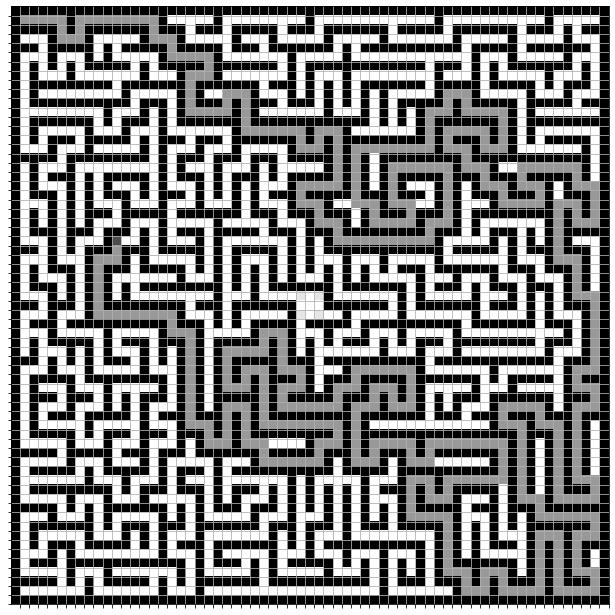

봇 회전 -> 이동(↑) 중
현재 진행시간:  98.20 sec


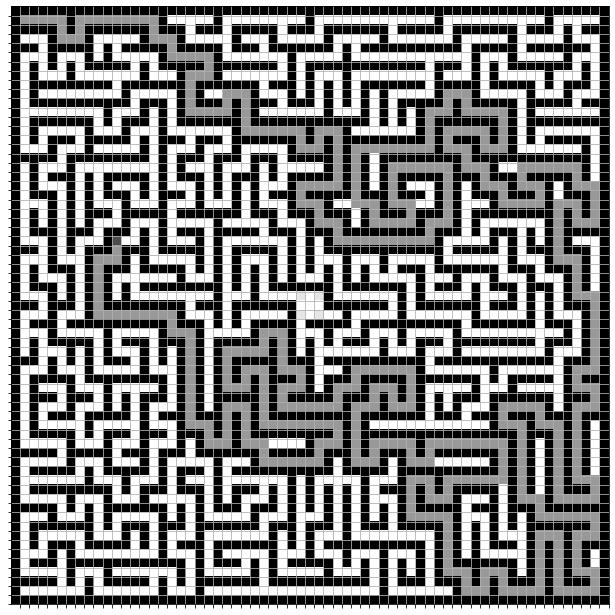

In [33]:
maze_agent.reset((1, 1))


current_cell = sol[0]
action = 2

actions_dict
status = ""
total_time = 0.0
for i, (mrow, mcol) in enumerate(sol):
    if i == 0:
        continue
        
    prev_action = action
    prev_cell = current_cell
    current_cell = (mrow, mcol)

    action_disc = (current_cell[0] - prev_cell[0], 
                current_cell[1] - prev_cell[1])
    if action_disc == (-1, 0):
        action = UP
    elif action_disc == (0, 1):
        action = RIGHT
    elif action_disc == (1, 0):
        action = DOWN
    elif action_disc == (0, -1):
        action = LEFT
    else:
        print("INVALID")
        break
        
    if prev_action == action:
        status = "이동"
        total_time += action_time
    else:
        status = "회전 -> 이동"
        total_time += rotate_time + action_time 

    try:

        plt.clf()
        
        canvas = maze_agent.act(action)
        img = maze_agent.show()
        display.clear_output(wait=True)

        display.display(plt.gcf())
        print(f"봇 {status}({arrow_dict[action]}) 중\n현재 진행시간: {total_time: .2f} sec", )

        time.sleep(1)
    except KeyboardInterrupt:
        break

# 2. 미로 탐색 학습

## 2.1. 트리 서치

## 2.2. `ConvNet`

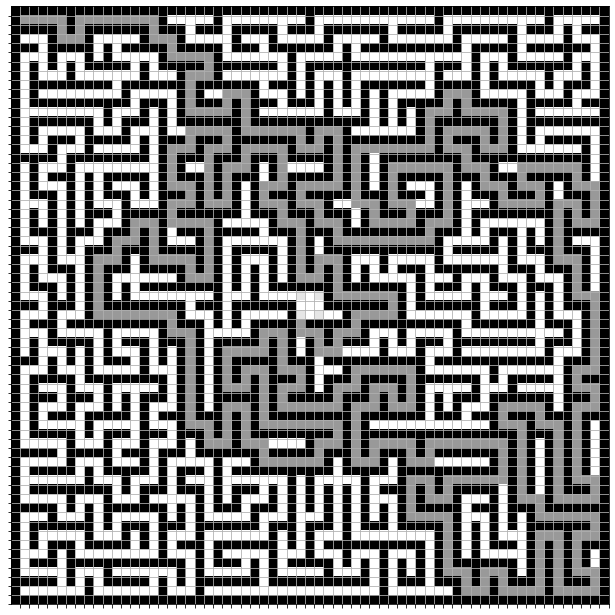

봇 이동 중 ↑


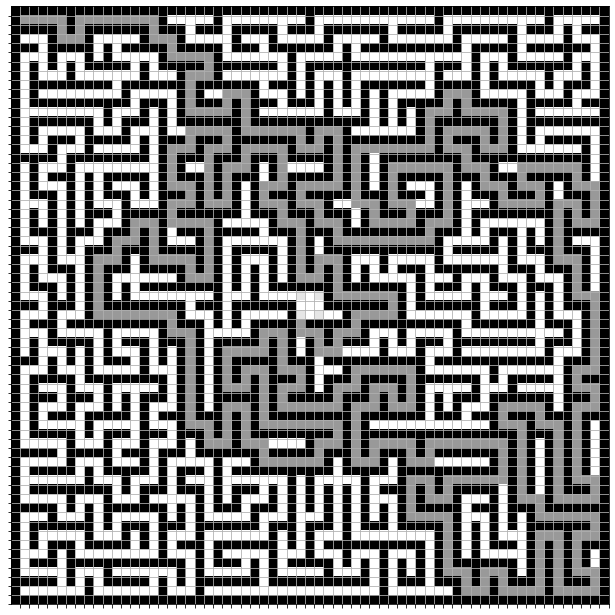

## 2.3. Q-Learning

# 3. 제출용 코드




In [3]:
from __future__ import print_function
import os, sys, time, datetime, json, random, collections, copy

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

from IPython import display
%matplotlib inline

plt.rcParams["figure.figsize"] = (11, 11)




class Room:
    def __init__(self, r, c):
        self.r, self.c = r, c
        self.visit = 0
        self.prev = None
        self.drct = [(r + 1, c), (r, c + 1),
                     (r - 1, c), (r, c - 1)]
        random.shuffle(self.drct)


class Maze:
    def __init__(self, size:int=32):
        self.size = size
        self.setup()
        
    def setup(self):
        self._maze = [[Room(r, c) for c in range(self.size)] for r in range(self.size)]
        self._mazeMap = [["1" for c in range(self.size * 2 + 1)] for r in range(self.size * 2 + 1)]
        self.__make(None, self._maze[0][0], self._maze)
        

        start = self.size - 1 # ()
        end = self.size + 1 # ()
        for i in range(start, end+1):
            for j in range(start, end+1):
                self._mazeMap[i][j] = "0"
                
        self._mazeMap[start][start] = self._mazeMap[start][end] = self._mazeMap[end][start] = self._mazeMap[end][end] = "3"
        self._mazeMap[1][1] = "2"
        self.maze = self._maze
        self.mazeMap = self._mazeMap
    
    def __make(self, prev, room:Room, maze:list):
        room.prev = prev
        if room.prev is not None:
            r = prev.r - room.r
            c = prev.c - room.c
            self._mazeMap[(room.r + 1) * 2 - 1 + r][(room.c + 1) * 2 - 1 + c] = "0"
            
        
        room.visit = 1
        self._mazeMap[(room.r + 1) * 2 - 1][(room.c + 1) * 2 - 1] = "0"
        while True:
            if len(room.drct) == 0:
                break
            nr, nc = room.drct.pop()
            if nr >= 0 and nr < self.size and nc >= 0 and nc < self.size:
                if not maze[nr][nc].visit == 1:
                    self.__make(room, maze[nr][nc], maze)
                
    def save(self, filename:str='maze.txt'):
        with open(filename, 'w') as f:
            for r in self.mazeMap:
                for c in r:
                    f.write(c)
                f.write('\n')

LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# For Train
information_dict = {
    "wall": 0.3,
    "free": 0.5,
    "visited": 0.75,
    "player": 0.9,
    "goal": 1.0

}

# For Drawing
mark_dict = {
    "wall": 0.0,
    "free": 1.0,
    "player": 0.3,
    "visited": 0.6,
    "goal": 0.9
}


# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

arrow_dict = {
    0: '←',
    1: '↑',
    2: '→',
    3: '↓'
}

head_dict = {
    0: '◀',
    1: '▲',
    2:'▶',
    3: '▼'
}


num_actions = len(actions_dict)


class Agent:
    def __init__(self, maze, player="2", goal="3"):
        self._convert_dict = {
            "0": information_dict["free"], # 이동가능
            "1": information_dict["wall"], # 벽
            player: information_dict["free"], # 플레이어
            goal: information_dict["free"] # 골인지점
        }
        self.player, self.target = (), []
        self._maze = self.__convert_maze_format(maze, player, goal)
        self.nrows, self.ncols = self._maze.shape
        self.free_cells = [(r, c) for r in range(self.nrows) for c in range(self.ncols) if self._maze[r, c] == information_dict["free"]]
        for tgt in self.target:
            self.free_cells.remove(tgt)
            if self._maze[tgt] == information_dict["wall"]:
                raise Exception("Invalid maze: target cell cannot be blocked!")
        if not self.player in self.free_cells:
            raise Exception("Invalid Player Location: must sit on a free cell")
        self.reset(self.player)            

    def __convert_maze_format(self, mazeMap:list, player, goal):
        maze_copy = copy.deepcopy(mazeMap)

        for i, line in enumerate(mazeMap):
            for j, elem in enumerate(mazeMap):
                current_elem = mazeMap[i][j]
                if current_elem == player:
                    self.player = (i, j)
                elif current_elem == goal:
                    self.target.append((i, j))
                maze_copy[i][j] = self._convert_dict[current_elem]

        return np.array(maze_copy)

    def reset(self, player):
        self.player = player
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = player
        self.maze[row, col] = information_dict["player"]
        self.state = (row, col, 'start')
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = player_row, player_col, mode = self.state

        if self.maze[player_row, player_col] > information_dict["wall"]:
            self.visited.add((player_row, player_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 2
                self.visited.add((player_row, player_col-1))
            elif action == UP:
                nrow -= 2
                self.visited.add((player_row-1, player_col))
            if action == RIGHT:
                ncol += 2
                self.visited.add((player_row, player_col+1))
            elif action == DOWN:
                nrow += 2
                self.visited.add((player_row+1, player_col))
                
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        
    def act(self, action):
        self.update_state(action)
        envstate = self.observe()
        return envstate

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = information_dict["free"]
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = information_dict["player"]
        return canvas

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        ## 가장자리 제거
        if row == 1: # UP 제거
            actions.remove(1)
        elif row == nrows-2: # DOWN 제거
            actions.remove(3)

        if col == 1: # LEFT 제거 
            actions.remove(0)
        elif col == ncols-2: # RIGHT 제거
            actions.remove(2)

        if row > 1 and self.maze[row-1,col] == information_dict["wall"]:
            actions.remove(1)
        if row<nrows-2 and self.maze[row+1,col] == information_dict["wall"]:
            actions.remove(3)

        if col>1 and self.maze[row,col-1] == information_dict["wall"]:
            actions.remove(0)
        if col<ncols-2 and self.maze[row,col+1] == information_dict["wall"]:
            actions.remove(2)

        return actions

    def show(self, external_maze=None):
        plt.grid('on')
        ax = plt.gca()
        ax.set_xticks(np.arange(0.5, self.nrows, 1))
        ax.set_yticks(np.arange(0.5, self.ncols, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if external_maze is not None:
            canvas = np.copy(external_maze)
        else:
            canvas = np.copy(self.maze)
        nrows, ncols = canvas.shape

        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = mark_dict["free"]
                else:
                    canvas[r, c] = mark_dict["wall"]


        for row, col in self.visited:
            canvas[row,col] = mark_dict["visited"]

        player_row, player_col, _ = self.state
        canvas[player_row, player_col] = mark_dict["player"]
        ## Goal Cell
        for target_row, target_col in self.target:
            canvas[target_row, target_col] = mark_dict["goal"]
        img = plt.imshow(canvas, interpolation='none', cmap='gray')
        return img

    def export_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = information_dict["free"]
        # draw the rat
        for row, col in self.visited:
            canvas[row,col] = information_dict["visited"]

        player_row, player_col, _ = self.state
        canvas[player_row, player_col] = information_dict["player"]
        
        ## Goal Cell
        for target_row, target_col in self.target:
            canvas[target_row, target_col] = information_dict["goal"]

        return canvas.reshape((1, -1))

    

def find_maze_solution(maze:list, player:tuple):
    def escRoot(pr, pc, prv, tree_map, search):
        """미로 탈출 경로 탐색
        * (pr, pc): 현재 위치
        * prv: 이전 위치
        """
        search.append((pr, pc))
        # 종료 분기
        for tmp in tree_map[pr][pc]:
            if (-1, -1) == tmp:
                sol.append((pr, pc))
                return 1

        for pos in tree_map[pr][pc]:
            if len(search) > 3000:
                print("unable to find solution on second")
                return 1
            if prv == pos:
                continue
            if escRoot(pos[0], pos[1], (pr, pc), tree_map, search) == 1:
                sol.append((pr, pc))
                return 1

    # with open(map_path, 'r') as rf:
    src = maze


    mazeSize = int((len(src) - 1)/2)
    tree_map, search, sol = [], [], []

    ## maze의 index 단위: maze 크기 만큼 이중 리스트 생성
    for r in range(1, mazeSize + 1):
        tree_map.append([])
        for c in range(1, mazeSize + 1):
            tree_map[-1].append([])

    ## mazeMap의 index 단위
    for  r in range(1, mazeSize*2, 2):
        for c in range(1, mazeSize*2, 2):
            rr, cc = int((r+1)/2)-1, int((c+1)/2)-1
            if src[r-1][c] == "0":
                tree_map[rr][cc].append((rr-1, cc))
            if src[r+1][c] == "0":
                tree_map[rr][cc].append((rr+1, cc))
            if src[r][c-1] == "0":
                tree_map[rr][cc].append((rr, cc-1))
            if src[r][c+1] == "0":
                tree_map[rr][cc].append((rr, cc+1))
                
            if src[r][c] == "3":
                tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
                

#     start = mazeSize - 1
#     end = mazeSize + 1
    
#     if is_first:

#         for r in range(start, end+1):
#             for c in range(start, end+1):
#                 if src[r][c] == "3":
#                     tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
                            


    escRoot(int((player[0]+1)/2 -1), int((player[1]+1)/2 -1), None, tree_map, search)

    sol.reverse()
    
    return sol, search




def read_maze(file):
    maze = []
    with open(file, 'r') as f:
        src = f.readlines()

    mapSize = int((len(src) - 1)/2)
    
    for i, row in enumerate(src):
        for j, item in enumerate(row.split('\n')[0]):
            if j == 0:
                maze.append([item])
            else:
                maze[i].append(item)
    start = mapSize - 1 
    end = mapSize + 1
    maze[start][start] = maze[start][end] = maze[end][start] = maze[end][end] = "3"
                
    return maze
            

    



def solve_on_maze(agent:Agent, solution:list, wait_time:float=1.0, is_visible:bool=True):
    
    agent.reset(agent.player)
    action_time, rotate_time = 0.3, 0.1


    current_cell = solution[0]
    action = 2

    status = ""
    total_time = 0.0
    for i, (mrow, mcol) in enumerate(solution):
        if i == 0:
            continue

        prev_action = action
        prev_cell = current_cell
        current_cell = (mrow, mcol)

        action_disc = (current_cell[0] - prev_cell[0], 
                    current_cell[1] - prev_cell[1])
        if action_disc == (-1, 0):
            action = UP
        elif action_disc == (0, 1):
            action = RIGHT
        elif action_disc == (1, 0):
            action = DOWN
        elif action_disc == (0, -1):
            action = LEFT
        else:
            print("INVALID")
            break

        if prev_action == action:
            status = "이동"
            total_time += action_time
        else:
            status = "회전 -> 이동"
            total_time += rotate_time + action_time 
            
        if is_visible:
            try:

                plt.clf()

                canvas = agent.act(action)
                img = agent.show()
                display.clear_output(wait=True)

                display.display(plt.gcf())
                if prev_action != action:
                    print(f"봇 헤드 방향: {head_dict[prev_action]} / {'회전중     '}\n현재 진행시간: {total_time - action_time: .2f} sec")
                print(f"봇 헤드 방향: {head_dict[action]} / {status}({arrow_dict[action]}) 중\n현재 진행시간: {total_time: .2f} sec", )
                time.sleep(wait_time)
            except KeyboardInterrupt:
                break
            plt.clf()
        else:
            canvas = agent.act(action)    
    return total_time

## 3.1. 정방향 (1회차)

In [1]:
filename = "../미로 1.txt"

maze = read_maze(filename)
maze_agent = Agent(maze)
maze_agent.show()

NameError: name 'read_maze' is not defined

97.30000000000011


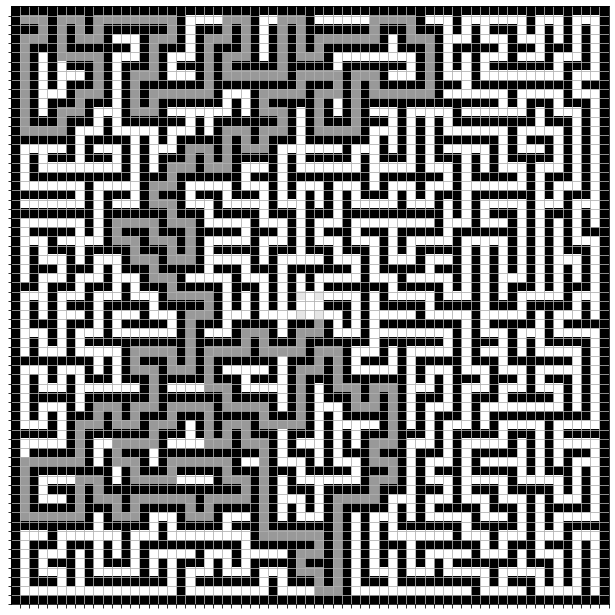

In [5]:
sol, search = find_maze_solution(maze, maze_agent.player)
print(solve_on_maze(maze_agent, sol, 0.1, False))
maze_agent.show()

## 3.2. 역방향 (2회차)

In [7]:
sol[-2]

(17, 16)

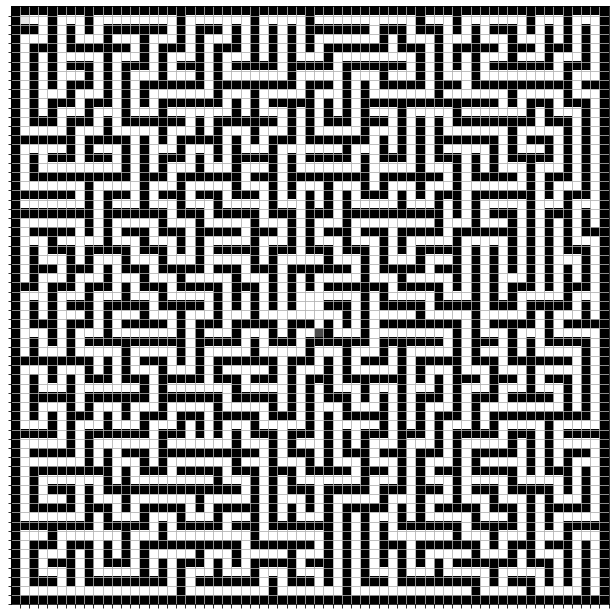

In [8]:
player = maze_agent.player
goal = tuple([(x +1)*2 - 1 for x in sol[-2]])

# Remove Visual Mark on Target
for x, y in maze_agent.target:
    maze[x][y] = '0'

maze[player[0]][player[1]] = '3'
maze[goal[0]][goal[1]] = '2'

maze_agent_end = Agent(maze)
maze_agent_end.show()

In [12]:
len(maze)

65

In [ ]:
def escRoot(pr, pc, prv, tree_map, search):
    """미로 탈출 경로 탐색
    * (pr, pc): 현재 위치
    * prv: 이전 위치
    """
    search.append((pr, pc))
    print((pr, pc))
    # 종료 분기
    for tmp in tree_map[pr][pc]:
        if (-1, -1) == tmp:
            sol.append((pr, pc))
            return 1

    for pos in tree_map[pr][pc]:
        if prv == pos:
            continue
        if escRoot(pos[0], pos[1], (pr, pc), tree_map, search) == 1:
            sol.append((pr, pc))
            return 1

src = maze


mazeSize = int((len(src) - 1)/2)
tree_map, search, sol = [], [], []

## maze의 index 단위: maze 크기 만큼 이중 리스트 생성
for r in range(1, mazeSize + 1):
    tree_map.append([])
    for c in range(1, mazeSize + 1):
        tree_map[-1].append([])

## mazeMap의 index 단위
for  r in range(1, mazeSize*2, 2):
    for c in range(1, mazeSize*2, 2):
        rr, cc = int((r+1)/2)-1, int((c+1)/2)-1
        if src[r-1][c] == "0":
            tree_map[rr][cc].append((rr-1, cc))
        if src[r+1][c] == "0":
            tree_map[rr][cc].append((rr+1, cc))
        if src[r][c-1] == "0":
            tree_map[rr][cc].append((rr, cc-1))
        if src[r][c+1] == "0":
            tree_map[rr][cc].append((rr, cc+1))

        if src[r][c] == "3":
            tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
            
escRoot(int((maze_agent_end.player[0]+1)/2 -1), int((player[1]+1)/2 -1), None, tree_map, search)

(17, 0)
(16, 0)
(15, 0)
(15, 1)
(14, 1)
(14, 2)
(13, 2)
(13, 1)
(12, 1)
(12, 0)
(11, 0)
(11, 1)
(11, 2)
(11, 3)
(12, 3)
(13, 3)
(12, 2)
(12, 4)
(11, 4)
(10, 4)
(9, 4)
(9, 5)
(9, 6)
(8, 6)
(7, 6)
(6, 6)
(6, 5)
(5, 5)
(4, 5)
(3, 5)
(2, 5)
(2, 6)
(1, 6)
(1, 5)
(5, 4)
(6, 4)
(6, 3)
(7, 3)
(8, 3)
(8, 2)
(8, 1)
(7, 1)
(7, 0)
(8, 0)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(10, 3)
(10, 2)
(10, 1)
(10, 0)
(7, 2)
(8, 4)
(8, 5)
(7, 5)
(7, 4)
(6, 7)
(7, 7)
(8, 7)
(7, 8)
(6, 8)
(6, 9)
(5, 9)
(5, 8)
(5, 10)
(6, 10)
(5, 11)
(4, 11)
(4, 12)
(5, 12)
(10, 6)
(10, 5)
(13, 0)
(14, 0)
(16, 1)
(18, 0)
(17, 1)
(18, 1)
(18, 2)
(17, 2)
(16, 2)
(15, 2)
(15, 3)
(14, 3)
(14, 4)
(13, 4)
(13, 5)
(14, 5)
(15, 5)
(15, 4)
(16, 4)
(17, 4)
(17, 3)
(18, 3)
(18, 4)
(19, 4)
(18, 5)
(19, 5)
(20, 5)
(20, 4)
(20, 3)
(19, 3)
(19, 2)
(20, 2)
(20, 1)
(19, 1)
(19, 0)
(20, 0)
(21, 0)
(22, 0)
(22, 1)
(21, 1)
(21, 2)
(22, 2)
(23, 2)
(23, 1)
(23, 0)
(24, 0)
(25, 0)
(26, 0)
(27, 0)
(27, 1)
(27, 2)
(27, 3)
(26, 3)
(25, 3)
(25, 2)
(25, 1)
(26, 1)
(

In [ ]:
def find_maze_solution(maze:list, player:tuple):


    # with open(map_path, 'r') as rf:

                

#     start = mazeSize - 1
#     end = mazeSize + 1
    
#     if is_first:

#         for r in range(start, end+1):
#             for c in range(start, end+1):
#                 if src[r][c] == "3":
#                     tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
                            


    

    sol.reverse()
    
    return sol, search

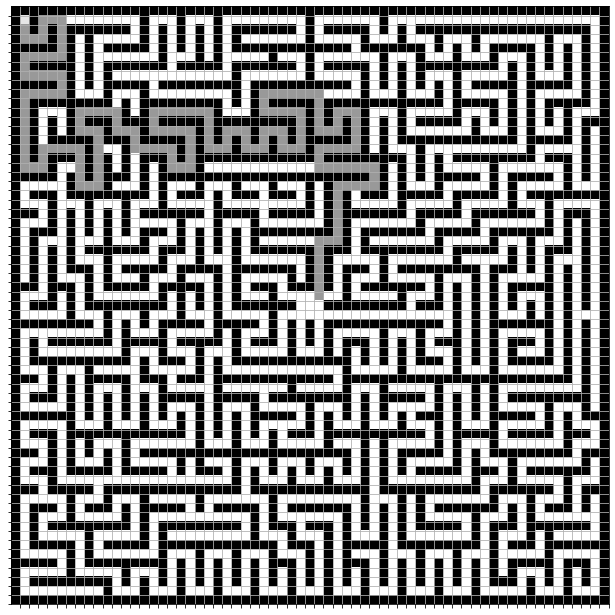

봇 헤드 방향: ◀ / 회전중     
현재 진행시간:  32.10 sec
봇 헤드 방향: ▲ / 회전 -> 이동(↑) 중
현재 진행시간:  32.40 sec


32.399999999999984

<Figure size 792x792 with 0 Axes>

In [28]:
sol_end, _ = find_maze_solution(maze, maze_agent_end.player)
solve_on_maze(maze_agent_end, sol_end, 0.1, True)